In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from torchsummary import summary

from fpga_nn_backend.datasets import *
from fpga_nn_backend.training import *
from fpga_nn_backend.evaluation import *
from fpga_nn_backend.models.relu_toy_models import *
from fpga_nn_backend.quantization import *
from fpga_nn_backend.fpga_simple.emulation import *
from fpga_nn_backend.fpga_simple.conversion import *
from fpga_nn_backend.utils import *

In [2]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version: 1.10.0
Torchvision Version: 0.11.1


In [3]:
data_dir = get_rel_pkg_path("dataset/")
weights_dir = get_rel_pkg_path("weights/")
session_dir = get_rel_pkg_path("sessions/")
models_dir = get_rel_pkg_path("models/")

In [4]:
dataset_type = ImageDatasetType.MNIST

In [5]:
orig_datasets = get_img_dataset(data_dir, dataset_type)

In [6]:
datasets = apply_img_transforms(orig_datasets, dataset_type, flatten=True)

In [7]:
dataloaders = get_dataloaders(datasets, 128, 128, num_workers=0)

In [8]:
input_dim = IMG_DATASET_TO_IMG_SIZE_FLAT[dataset_type]
num_classes = IMG_DATASET_TO_NUM_CLASSES[dataset_type]

model = ReLUToyModel(input_dim, num_classes, layer_dims=[])
model = model.to(device)

In [9]:
model = QuantWrapper(model)

In [10]:
summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,840
      ReLUToyModel-3                   [-1, 10]               0
       DeQuantStub-4                   [-1, 10]               0
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [11]:
# model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 11-18-2021 11-04-36 PM\Weights Best.pckl")))

In [12]:
# model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 11-20-2021 06-39-40 PM\Weights Best.pckl")))

In [13]:
model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 12-07-2021 11-47-53 PM\Weights Best.pckl")))

<All keys matched successfully>

In [14]:
criterion = get_loss()
criterion = criterion.to(device)

In [15]:
model.eval()
qconfig = torch.quantization.QConfig(
    activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8),
    weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8))
#qconfig = torch.quantization.get_default_qconfig('fbgemm')
model.qconfig = qconfig
#torch.quantization.fuse_modules(model.model.layers, [['0', '1'], ['2', '3'], ['4', '5'], ['6', '7']], inplace=True)
model = torch.quantization.prepare(model)
stats = get_dataloader_stats(dataloaders['test'], model, criterion, device)
model_int8 = torch.quantization.convert(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.01it/s]


In [16]:
print("Accuracy:", stats['acc'])

Accuracy: 0.9034


In [17]:
model_int8

QuantWrapper(
  (model): ReLUToyModel(
    (layers): Sequential(
      (0): QuantizedLinear(in_features=784, out_features=10, scale=0.10827332735061646, zero_point=125, qscheme=torch.per_tensor_affine)
    )
  )
  (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [18]:
model_int8.model.layers[0].weight().int_repr()

tensor([[ -8, -23, -24,  ..., -19,  -7,  -9],
        [-18, -23, -17,  ..., -20, -17, -19],
        [ -4, -24, -24,  ..., -14, -15,  -7],
        ...,
        [-19, -24,  -8,  ..., -17,  -7, -22],
        [ -4, -10,  -7,  ..., -16,  -7, -22],
        [-21, -12, -11,  ...,  -7,  -5, -14]], dtype=torch.int8)

In [19]:
model_int8.model.layers[0].weight()

tensor([[ 0.0207, -0.0310, -0.0344,  ..., -0.0172,  0.0241,  0.0172],
        [-0.0138, -0.0310, -0.0103,  ..., -0.0207, -0.0103, -0.0172],
        [ 0.0344, -0.0344, -0.0344,  ...,  0.0000, -0.0034,  0.0241],
        ...,
        [-0.0172, -0.0344,  0.0207,  ..., -0.0103,  0.0241, -0.0276],
        [ 0.0344,  0.0138,  0.0241,  ..., -0.0069,  0.0241, -0.0276],
        [-0.0241,  0.0069,  0.0103,  ...,  0.0241,  0.0310,  0.0000]],
       size=(10, 784), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003444838570430875,
       zero_point=-14)

In [20]:
stats = get_dataloader_stats(dataloaders['test'], model_int8, criterion, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.98it/s]


In [21]:
print("Accuracy:", stats['acc'])

Accuracy: 0.9009


In [22]:
def safe_get_param(param):
    if param is not None:
        return param.int_repr().numpy()
    else:
        return None

In [23]:
converted_nn = ConvertedNN((1, 28, 28))

converted_nn.add_flatten_layer((1, 28, 28), 0, 0)

converted_nn.add_dense_layer((784,), (10,), 0, 1,
    weight=safe_get_param(model_int8.model.layers[0].weight()),
    bias=safe_get_param(model_int8.model.layers[0].bias()))

converted_nn.add_output_layer((10,), 1, 1)

In [24]:
model_int8.model.layers[0]

QuantizedLinear(in_features=784, out_features=10, scale=0.10827332735061646, zero_point=125, qscheme=torch.per_tensor_affine)

In [25]:
converted_nn.finalize()

In [26]:
converted_nn.get_layer_info()

{'layers': [{'layer_type': <ConverterLayerType.FLATTEN: 5>,
   'input_shapes': ((1, 28, 28),),
   'output_shape': (784,),
   'output_size': 784,
   'stack_input_indices': (0,),
   'stack_output_index': 0,
   'parameters': None,
   'metadata': None},
  {'layer_type': <ConverterLayerType.DENSE: 0>,
   'input_shapes': ((784,),),
   'output_shape': (10,),
   'output_size': 10,
   'stack_input_indices': (0,),
   'stack_output_index': 1,
   'parameters': {'weight': 0},
   'metadata': {'has_bias': False}},
  {'layer_type': <ConverterLayerType.OUTPUT: 7>,
   'input_shapes': ((10,),),
   'output_shape': (10,),
   'output_size': 10,
   'stack_input_indices': (1,),
   'stack_output_index': 1,
   'parameters': None,
   'metadata': None}]}

In [27]:
with open("test.coe", 'w') as f:
    f.write(converted_nn.generate_parameter_coe())

In [28]:
emulator = FPGAEmulator(converted_nn, bram_reserved_size=303000)

In [29]:
index = 1
for imgs, labels in dataloaders['test']:
    break
data = (imgs[index] * 255).numpy()
data = data.astype(np.uint8)
print(data)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 116 125 171 255 255 150  93   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 169 253 253 253 253
 253 253 218  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 169 253 253 253 213 142 176 253 253 122   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  52 250 253 210  32
  12   0   6 206 253 140   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  77 251 210  25   0   0   0 122 248 253  65   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  31  18
   0   0   0   0 209 253 253  65   0   0   0   0   

In [30]:
parameters = converted_nn.parameters_info['parameters']

In [31]:
inputs_per_layer = {}
outputs_per_layer = {}
def get_output(name):
    def hook(model, input, output):
        inputs_per_layer[name] = input
        outputs_per_layer[name] = output.detach()
    return hook

hooks = {}
for name, module in model_int8.named_modules():
    hooks[name] = module.register_forward_hook(get_output(name))

In [32]:
batch = imgs[None, index, :]
model_out = model_int8(batch)

In [33]:
inputs_per_layer['model.layers.0'][0].int_repr()

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 116, 125, 171, 255,
         255, 150,  93,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0, 169, 253, 253, 253, 253,
         253, 253, 218,  30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0, 169, 253, 253, 253, 213, 142,
         176, 253, 253, 122,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,  52, 250

In [34]:
outputs_per_layer['model.layers.0'].int_repr()

tensor([[147, 112, 185, 151,  70, 151, 161,  66, 144,  79]], dtype=torch.uint8)

In [35]:
model_int8.model.layers[0].weight()

tensor([[ 0.0207, -0.0310, -0.0344,  ..., -0.0172,  0.0241,  0.0172],
        [-0.0138, -0.0310, -0.0103,  ..., -0.0207, -0.0103, -0.0172],
        [ 0.0344, -0.0344, -0.0344,  ...,  0.0000, -0.0034,  0.0241],
        ...,
        [-0.0172, -0.0344,  0.0207,  ..., -0.0103,  0.0241, -0.0276],
        [ 0.0344,  0.0138,  0.0241,  ..., -0.0069,  0.0241, -0.0276],
        [-0.0241,  0.0069,  0.0103,  ...,  0.0241,  0.0310,  0.0000]],
       size=(10, 784), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003444838570430875,
       zero_point=-14)

In [36]:
out = emulator.execute(data)
print(out)

[-226325, -517266, 62549, -199621, -899189, -196677, -112234, -939653, -249692, -779382]


In [37]:
np.argsort(outputs_per_layer['model.layers.0'].int_repr().numpy())

array([[7, 4, 9, 1, 8, 0, 3, 5, 6, 2]], dtype=int64)

In [38]:
np.argsort(out)

array([7, 4, 9, 1, 8, 0, 3, 5, 6, 2], dtype=int64)

In [39]:
labels[index].numpy()

array(2, dtype=int64)

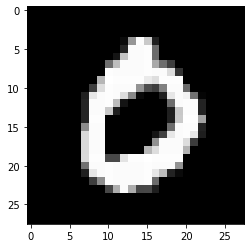

MNIST index: 3, True label: 0, Predicted label: 0, Prediction outputs (dec): [96790, -1125558, -471190, -564059, -885522, -344717, -389707, -443187, -524548, -556185], Prediction outputs (hex): ['0x17a16', '0xffeed34a', '0xfff8cf6a', '0xfff764a5', '0xfff27cee', '0xfffabd73', '0xfffa0db5', '0xfff93ccd', '0xfff7fefc', '0xfff78367']


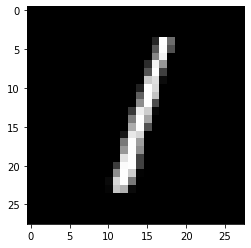

MNIST index: 2, True label: 1, Predicted label: 1, Prediction outputs (dec): [-340534, 223277, -64869, -108887, -267539, -207288, -144836, -139497, -70500, -198918], Prediction outputs (hex): ['0xfffacdca', '0x3682d', '0xffff029b', '0xfffe56a9', '0xfffbeaed', '0xfffcd648', '0xfffdca3c', '0xfffddf17', '0xfffeec9c', '0xfffcf6fa']


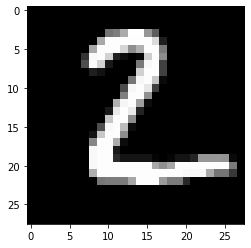

MNIST index: 1, True label: 2, Predicted label: 2, Prediction outputs (dec): [-226325, -517266, 62549, -199621, -899189, -196677, -112234, -939653, -249692, -779382], Prediction outputs (hex): ['0xfffc8beb', '0xfff81b6e', '0xf455', '0xfffcf43b', '0xfff2478b', '0xfffcffbb', '0xfffe4996', '0xfff1a97b', '0xfffc30a4', '0xfff41b8a']


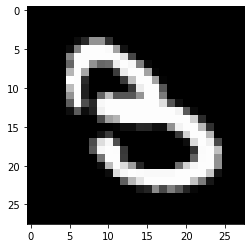

MNIST index: 18, True label: 3, Predicted label: 3, Prediction outputs (dec): [-684668, -612067, -401094, -255149, -577847, -387941, -377252, -644403, -431730, -568482], Prediction outputs (hex): ['0xfff58d84', '0xfff6a91d', '0xfff9e13a', '0xfffc1b53', '0xfff72ec9', '0xfffa149b', '0xfffa3e5c', '0xfff62acd', '0xfff9698e', '0xfff7535e']


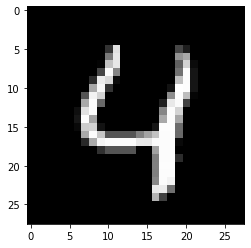

MNIST index: 4, True label: 4, Predicted label: 4, Prediction outputs (dec): [-340341, -644053, -224736, -420414, 56753, -380377, -244932, -204809, -209516, -117576], Prediction outputs (hex): ['0xffface8b', '0xfff62c2b', '0xfffc9220', '0xfff995c2', '0xddb1', '0xfffa3227', '0xfffc433c', '0xfffcdff7', '0xfffccd94', '0xfffe34b8']


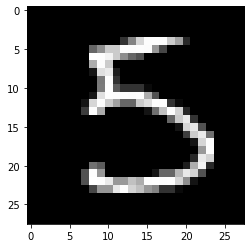

MNIST index: 15, True label: 5, Predicted label: 5, Prediction outputs (dec): [-269861, -461232, -291014, -153397, -379985, 395, -454630, -379927, -139587, -505936], Prediction outputs (hex): ['0xfffbe1db', '0xfff8f650', '0xfffb8f3a', '0xfffda8cb', '0xfffa33af', '0x18b', '0xfff9101a', '0xfffa33e9', '0xfffddebd', '0xfff847b0']


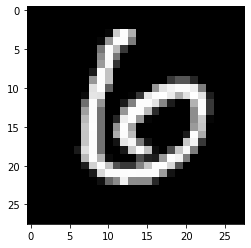

MNIST index: 11, True label: 6, Predicted label: 6, Prediction outputs (dec): [-349536, -477725, -284844, -397796, -404215, -446648, -159838, -627023, -216662, -522502], Prediction outputs (hex): ['0xfffaaaa0', '0xfff8b5e3', '0xfffba754', '0xfff9ee1c', '0xfff9d509', '0xfff92f48', '0xfffd8fa2', '0xfff66eb1', '0xfffcb1aa', '0xfff806fa']


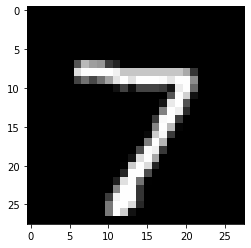

MNIST index: 0, True label: 7, Predicted label: 7, Prediction outputs (dec): [-259129, -640751, -275463, -122498, -359409, -340971, -551358, 329339, -260698, -72963], Prediction outputs (hex): ['0xfffc0bc7', '0xfff63911', '0xfffbcbf9', '0xfffe217e', '0xfffa840f', '0xfffacc15', '0xfff79642', '0x5067b', '0xfffc05a6', '0xfffee2fd']


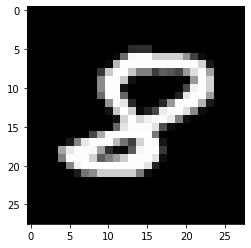

MNIST index: 61, True label: 8, Predicted label: 8, Prediction outputs (dec): [-422557, -764730, -206829, -688038, -553237, -351321, -369825, -703672, -105198, -340864], Prediction outputs (hex): ['0xfff98d63', '0xfff454c6', '0xfffcd813', '0xfff5805a', '0xfff78eeb', '0xfffaa3a7', '0xfffa5b5f', '0xfff54348', '0xfffe6512', '0xfffacc80']


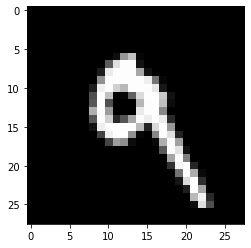

MNIST index: 7, True label: 9, Predicted label: 9, Prediction outputs (dec): [-644702, -369852, -385614, -295065, -155661, -232185, -347589, -317638, -228225, 5126], Prediction outputs (hex): ['0xfff629a2', '0xfffa5b44', '0xfffa1db2', '0xfffb7f67', '0xfffd9ff3', '0xfffc7507', '0xfffab23b', '0xfffb273a', '0xfffc847f', '0x1406']


In [40]:
for imgs, labels in dataloaders['test']:
    break

packed_arrays = ""
indices = [0, 1, 2, 3, 4, 7, 11, 15, 18, 61]
labels_part = [labels[i] for i in indices]
reordered_indices = [indices[i] for i in np.argsort(labels_part)]

for i in reordered_indices:
    data = (imgs[i] * 255).numpy()
    data = data.astype(np.uint8)
    plt.imshow(data.reshape(28, 28), cmap='gray')
    plt.show()
    out = emulator.execute(data)
    out_hex = [hex(np.uint32(n)) for n in out]
    print("MNIST index: {}, True label: {}, Predicted label: {}, Prediction outputs (dec): {}, Prediction outputs (hex): {}".format(
        i, int(labels[i].numpy()), np.argmax(out), out, out_hex))
    
    sample_img = data[::-1]
    packed_array = "logic signed [DATA_BITS-1:0] sample_img [IMG_SIZE*IMG_SIZE-1:0] = {"
    for i, s in enumerate(sample_img):
        packed_array = packed_array + f"32'h{hex(s)[2:]}"
        if i != len(sample_img) - 1:
            packed_array = packed_array + ", "
    packed_array = packed_array + "};"
    packed_arrays += (packed_array + "\n")

with open("img_arrays.sv", 'w') as f:
    f.write(packed_arrays)